In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from scipy import stats
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from scipy import interpolate

from jaxbo.models import GP
from jaxbo.utils import normalize

import jaxbo.acquisitions as acquisitions
import jaxbo.utils as utils
from jaxbo.input_priors import uniform_prior

from sklearn import mixture
from pyDOE import lhs


onp.random.seed(1234)


In [2]:
class run_simulations:
    # Initialize the class
    def __init__(self, data_test, xs_in, sigma_in, T_in, MC_samples_in):
        
        # Initialize the model
        self.Data = data_test
        self.N_dim = self.Data.shape[0]
        
        self.xs = xs_in
        self.sigma = sigma_in
        self.T = T_in
        self.MC_samples = MC_samples_in
        self.delta = 0.1
        self.jitter = 1e-8
        self.N_init = 3
        
        # define GP model and JAX GP options
        self.dim = xs_in.shape[1]
        self.lb = 0.0*np.ones(self.dim)
        self.ub = 1.0*np.ones(self.dim)
        self.bounds = {'lb': self.lb, 'ub': self.ub}
        self.p_x = uniform_prior(self.lb, self.ub)
        self.options = {'kernel': 'RBF', 'input_prior': self.p_x}
        self.gp_model = GP(self.options)
        
        self.rng_key = random.PRNGKey(0)
        
        
    # Different types of acquisition functions
    def acquisition_functions(self, mu, std, y_sample, best, beta = 1.0, weights = 0, method = "LCB"):
        kappa = 1.0
        if method == "LCB":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], np.sqrt(beta))
        if method == "LCB_v":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], kappa)
        if method == "mean":
            return mu
        if method == "LW_LCB":
            return vmap(acquisitions.LW_LCB, in_axes=(0,0,0,None))(mu[:,None], std[:,None], weights[:,None], kappa)
        if method == "TS":
            return y_sample
        if method == "EI":
            return vmap(acquisitions.EI, in_axes=(0,0,None))(mu[:,None], std[:,None], best)
    
    
    def compute_weights(self, x):
        
        weights = utils.compute_w_gmm(x, **self.kwargs)
        self.weights = weights
        
        return weights
        
    def compute_beta(self, t):
        beta = 2 * np.log(t**2*np.pi**2/(6 * self.delta))
        beta = beta / 5.
        return beta

    def compute_mu_std_sample(self, X, y, X_star, rng_key, compute_weight = False):
        
        # Fetch normalized training data
        norm_batch, norm_const = normalize(X, y, self.bounds)

        # Train GP model
        opt_params = self.gp_model.train(norm_batch, rng_key, num_restarts = 10)
        
        # Define the dictionary to feed in the GP regression 
        self.kwargs = {'params': opt_params, 
                  'batch': norm_batch, 
                  'norm_const': norm_const, 
                  'bounds': self.bounds,
                  'rng_key': rng_key}
        
        if compute_weight:
            gmm_vars = self.gp_model.fit_gmm(**self.kwargs, N_samples = 10000)

            self.kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': self.bounds,
                  'gmm_vars': gmm_vars,
                  'rng_key': rng_key}

        # Draw posterior mean and std and a sample from posterior distribution 
        mu, std = self.gp_model.predict(X_star, **self.kwargs)
        y_sample = self.gp_model.draw_posterior_sample(X_star, **self.kwargs)
        
        mu, std = mu * norm_const['sigma_y'] + norm_const['mu_y'], std *norm_const['sigma_y']
        y_sample = y_sample * norm_const['sigma_y'] + norm_const['mu_y']
        
        return mu, std, y_sample
        
        
    def run_one_trial(self, sample_idx, method = "LCB"):
        
        # the testing data for the current MC trial
        data = self.Data[:,sample_idx]
        x_cand = self.xs
        
        # inital random observation
        idx_init = onp.random.randint(self.N_dim, size = self.N_init) #[np.random.randint(self.N_dim)]
        print(idx_init)
        
        # check the shape (Y is vector not array)
        Y = data[idx_init]
        X = x_cand[idx_init,:]
        
        regrets = []
        
        # get the best payoff
        index_best = np.argmin(data)
        Y_best = data[index_best]
        
        # start to record the regret
        regrets.append(abs(Y_best - np.min(Y)))
        
        rng_key = random.split(self.rng_key)[0]
        # start the active learning
        for t in range(1, self.T):
        
            # compute beta and modify correspondingly according to inital number of data
            beta = self.compute_beta(t + self.N_init - 1)
            
            #print("X, Y", X.shape, Y.shape, X, Y)
            
            if method == "LW_LCB":
                compute_weight = True
            else:
                compute_weight = False
            
            # compute GP posterior mean and std
            rng_key = random.split(rng_key)[0]
            mu, std, y_sample = self.compute_mu_std_sample(X, Y, self.xs, rng_key, compute_weight)

            # best for the EI if needed
            best = np.min(Y)
            
            # compute the weight for the LW-LCB if needed
            if method == "LW_LCB":
                weights = self.compute_weights(x_cand)
            else:
                weights = 0
                
            # compute acquisition function
            acquisition_fun = self.acquisition_functions(mu, std, y_sample, best, beta, weights, method)

            # find the index best location to explore 
            best_index = np.argmin(acquisition_fun)
            
            # find the best location to explore
            X_new = x_cand[best_index:best_index+1,:]
            
            # observe the noisy reward
            Y_new = data[best_index] + onp.random.normal(0, self.sigma, 1)
            
            #print(X.shape, Y.shape, X_new.shape, Y_new.shape)
            # update X and Y
            X = np.concatenate([X, X_new], axis = 0)
            Y = np.concatenate([Y, Y_new], axis = 0)
            
            regrets.append(abs(Y_best - Y_new[0]))
            #regrets.append(abs(Y_best - min(Y)))
            
            if t == self.T - 1 and method == "LW_LCB":
                
                weights_plot = None

            if method == "LW_LCB":
                continue
            else:
                weights_plot = None
            
        return regrets, X, weights_plot
        
    def train(self):
        
        regrets_LCB = []
        regrets_LCB_v = []
        regrets_mean = []
        regrets_TS = []
        regrets_EI = []
        regrets_LW_LCB = []
        
        X_LCB = []
        X_LCB_v = []
        X_mean = []
        X_TS = []
        X_EI = []
        X_LW_LCB = []
                

        for k in range(self.MC_samples):
            if k % 1 == 0:
                print(k)
            
            try: 
                regrets_1, X_1, weights_plot_1 = self.run_one_trial(k, method = "LW_LCB")
                regrets_2, X_2, _ = self.run_one_trial(k, method = "LCB")
                regrets_3, X_3, _ = self.run_one_trial(k, method = "LCB_v")
                regrets_4, X_4, _ = self.run_one_trial(k, method = "mean")
                regrets_5, X_5, _ = self.run_one_trial(k, method = "TS")
                regrets_6, X_6, _ = self.run_one_trial(k, method = "EI")
                regrets_LW_LCB.append(regrets_1)
                X_LW_LCB.append(X_1)
                regrets_LCB.append(regrets_2)
                X_LCB.append(X_2)
                regrets_LCB_v.append(regrets_3)
                X_LCB_v.append(X_3)
                regrets_mean.append(regrets_4)
                X_mean.append(X_4)
                regrets_TS.append(regrets_5)
                X_TS.append(X_5)
                regrets_EI.append(regrets_6)
                X_EI.append(X_6)
            except: 
                regrets_LW_LCB.append(regrets_1)
                X_LW_LCB.append(X_1)
                regrets_LCB.append(regrets_2)
                X_LCB.append(X_2)
                regrets_LCB_v.append(regrets_3)
                X_LCB_v.append(X_3)
                regrets_mean.append(regrets_4)
                X_mean.append(X_4)
                regrets_TS.append(regrets_5)
                X_TS.append(X_5)
                regrets_EI.append(regrets_6)
                X_EI.append(X_6)
                continue
                    

        regrets_LCB = np.asarray(regrets_LCB)
        regrets_LCB_v = np.asarray(regrets_LCB_v)
        regrets_mean = np.asarray(regrets_mean)
        regrets_TS = np.asarray(regrets_TS)
        regrets_EI = np.asarray(regrets_EI)
        regrets_LW_LCB = np.asarray(regrets_LW_LCB)
        
        X_LCB = np.asarray(X_LCB)
        X_LCB_v = np.asarray(X_LCB_v)
        X_mean = np.asarray(X_mean)
        X_TS = np.asarray(X_TS)
        X_EI = np.asarray(X_EI)
        X_LW_LCB = np.asarray(X_LW_LCB)
        
        
        print(regrets_LCB.shape, regrets_LCB_v.shape, regrets_mean.shape, regrets_TS.shape, regrets_EI.shape, regrets_LW_LCB.shape, \
                X_LCB.shape, X_LCB_v.shape, X_mean.shape, X_TS.shape, X_EI.shape, X_LW_LCB.shape)
        
        return regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
                X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB
            




[[0.32050422 0.44883067 0.27906977]
 [0.47431084 0.43543905 0.5503876 ]
 [0.49982155 0.61044027 0.84496124]
 [0.69574155 0.54357966 0.72868217]
 [0.31497951 0.         0.03875969]
 [0.21974618 0.27873755 0.24031008]
 [0.1401162  0.42251873 0.33333333]
 [1.         0.75935707 0.17054264]
 [0.367143   0.42165738 0.46511628]
 [0.66453483 0.35577189 0.66666667]
 [0.34681437 0.57574231 0.76744186]
 [0.32413025 0.76696299 0.58139535]
 [0.63258576 0.23996035 0.60465116]
 [0.45115562 0.29823991 0.        ]
 [0.43295408 0.54270205 0.59689922]
 [0.47295465 0.39378525 0.48837209]
 [0.44116261 0.69291902 1.        ]
 [0.83510114 0.1509158  0.21705426]
 [0.99631686 0.67512311 0.14728682]
 [0.28719896 0.22130308 0.03875969]
 [0.58643235 0.86046058 0.78294574]
 [0.         1.         0.12403101]
 [0.85074733 0.69103379 0.47286822]
 [0.43606618 0.89779136 0.89922481]]
[[0.32050422 0.44883067 0.27906977]
 [0.47431084 0.43543905 0.5503876 ]
 [0.49982155 0.61044027 0.84496124]
 [0.69574155 0.54357966 0.7

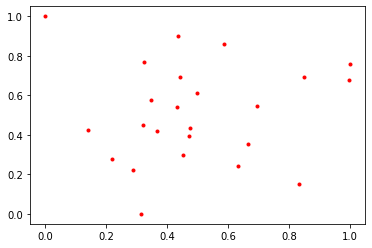

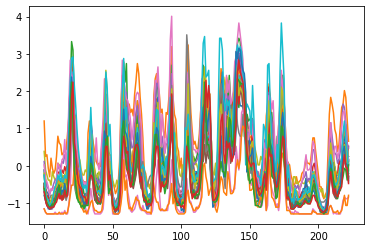

In [3]:
# load the data and normalize the data
Y_data = np.load("Data.npy")
xs = np.load("Locations_3D.npy")

Y_data = np.array(Y_data)
xs = np.array(xs)

print(xs) 

lb = np.min(xs, axis = 0)
ub = np.max(xs, axis = 0)

xs = (xs - lb)/(ub - lb)

print(xs)

plt.figure(-2, figsize = (6, 4))
plt.plot(xs[:,0], xs[:,1], 'r.')
plt.show()

Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)

plt.figure(-1, figsize = (6, 4))
for k in range(Y_data.shape[0]):
    plt.plot(Y_data[k,:])
    

Y_data = - onp.asarray(Y_data)
    

In [4]:
print(Y_data.shape)
print(xs.shape)



(24, 223)
(24, 3)


In [5]:
# K from 0 to 8, we do not do all of them in one shot
K = 0
MC_samples = 5 # 200
nn = 50


# Fetch training data
Y_data = Y_data[:,K*MC_samples:(K+1)*MC_samples]
print(Y_data.shape)


sigma = np.sqrt(1e-8) 
T = 50



(24, 5)


In [6]:
print(Y_data.shape)
print(xs.shape)



(24, 5)
(24, 3)


In [7]:
model = run_simulations(Y_data, xs, sigma, T, MC_samples)
regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB = model.train()

np.save("regrets_LCB" + str(K), regrets_LCB)
np.save("regrets_LCB_v" + str(K), regrets_LCB_v)
np.save("regrets_mean" + str(K), regrets_mean)
np.save("regrets_TS" + str(K), regrets_TS)
np.save("regrets_EI" + str(K), regrets_EI)
np.save("regrets_LW_LCB" + str(K), regrets_LW_LCB)

np.save("X_LCB" + str(K), X_LCB)
np.save("X_LCB_v" + str(K), X_LCB_v)
np.save("X_mean" + str(K), X_mean)
np.save("X_TS" + str(K), X_TS)
np.save("X_EI" + str(K), X_EI)
np.save("X_LW_LCB" + str(K), X_LW_LCB)




0
[15 19  6]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


[ 2 13  0]
[13 14  7]
[10  1 15]
[ 6 22 19]
[20 19 16]
1
[23  4 15]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


[ 7  7 15]
2
[ 9 16  0]
[ 2  3 10]
[22 12 19]
[19 18 21]
[12 17  1]
[12  6  1]
3
[18 13 19]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


[ 7 16  7]
[ 0 12 13]
[13 10 10]
[19  0 17]
[14 10 13]
4
[12  6  3]
[12 10 21]
[ 3 12 13]
[13  3  5]
[20 12 15]
[10  9 23]
(5, 50) (5, 50) (5, 50) (5, 50) (5, 50) (5, 50) (5, 52, 3) (5, 52, 3) (5, 52, 3) (5, 52, 3) (5, 52, 3) (5, 52, 3)


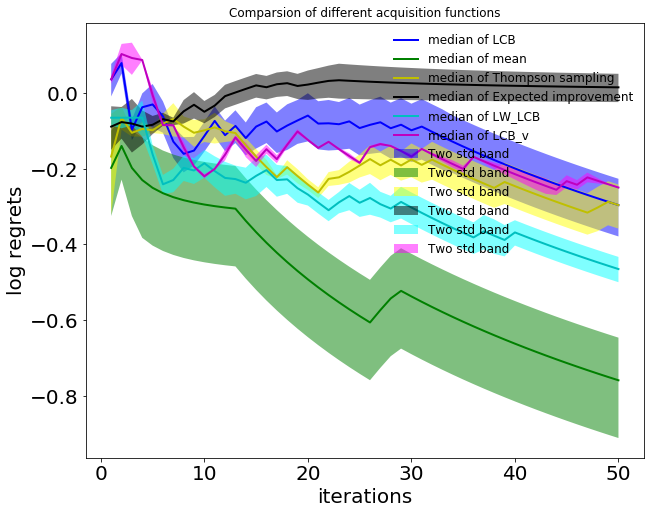

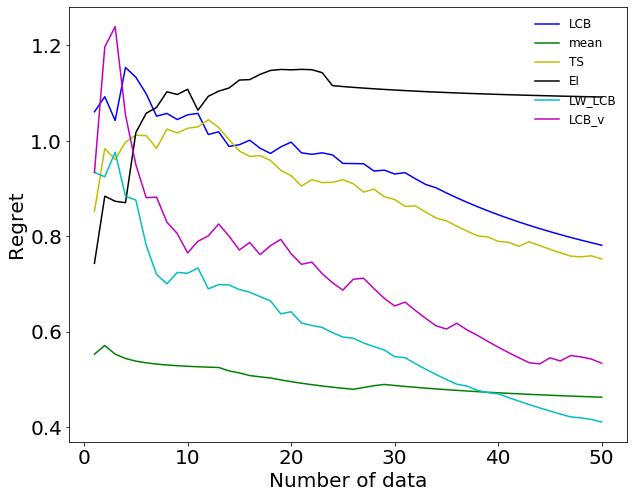

In [8]:
times = np.arange(T) + 1


regrets_LCB = np.cumsum(regrets_LCB, axis = 1) / times
regrets_LCB_v = np.cumsum(regrets_LCB_v, axis = 1) / times
regrets_mean = np.cumsum(regrets_mean, axis = 1) / times
regrets_TS = np.cumsum(regrets_TS, axis = 1) / times
regrets_EI = np.cumsum(regrets_EI, axis = 1) / times
regrets_LW_LCB = np.cumsum(regrets_LW_LCB, axis = 1) / times



dispersion_scale = 0.2

y1_mu, y1_std = np.median(regrets_LCB, axis = 0), stats.median_absolute_deviation(regrets_LCB, axis = 0)
y2_mu, y2_std = np.median(regrets_mean, axis = 0), stats.median_absolute_deviation(regrets_mean, axis = 0)
y4_mu, y4_std = np.median(regrets_TS, axis = 0), stats.median_absolute_deviation(regrets_TS, axis = 0)
y5_mu, y5_std = np.median(regrets_EI, axis = 0), stats.median_absolute_deviation(regrets_EI, axis = 0)
y6_mu, y6_std = np.median(regrets_LW_LCB, axis = 0), stats.median_absolute_deviation(regrets_LW_LCB, axis = 0)
y7_mu, y7_std = np.median(regrets_LCB_v, axis = 0), stats.median_absolute_deviation(regrets_LCB_v, axis = 0)



ax = plt.figure(1,figsize=(10,8))
plt.title('Comparsion of different acquisition functions')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lower1 = np.log10(np.clip(y1_mu - dispersion_scale*y1_std, a_min=0., a_max = np.inf) + 1e-8)
upper1 = np.log10(y1_mu + dispersion_scale*y1_std + 1e-8)
plt.fill_between(times.flatten(), lower1.flatten(), upper1.flatten(), 
                 facecolor='blue', alpha=0.5, label="Two std band")
lower2 = np.log10(np.clip(y2_mu - dispersion_scale*y2_std, a_min=0., a_max = np.inf) + 1e-8)
upper2 = np.log10(y2_mu + dispersion_scale*y2_std + 1e-8)
plt.fill_between(times.flatten(), lower2.flatten(), upper2.flatten(), 
                 facecolor='green', alpha=0.5, label="Two std band")
lower4 = np.log10(np.clip(y4_mu - dispersion_scale*y4_std, a_min=0., a_max = np.inf) + 1e-8)
upper4 = np.log10(y4_mu + dispersion_scale*y4_std + 1e-8)
plt.fill_between(times.flatten(), lower4.flatten(), upper4.flatten(), 
                 facecolor='yellow', alpha=0.5, label="Two std band")
lower5 = np.log10(np.clip(y5_mu - dispersion_scale*y5_std, a_min=0., a_max = np.inf) + 1e-8)
upper5 = np.log10(y5_mu + dispersion_scale*y5_std + 1e-8)
plt.fill_between(times.flatten(), lower5.flatten(), upper5.flatten(), 
                 facecolor='black', alpha=0.5, label="Two std band")
lower6 = np.log10(np.clip(y6_mu - dispersion_scale*y6_std, a_min=0., a_max = np.inf) + 1e-8)
upper6 = np.log10(y6_mu + dispersion_scale*y6_std + 1e-8)
plt.fill_between(times.flatten(), lower6.flatten(), upper6.flatten(), 
                 facecolor='cyan', alpha=0.5, label="Two std band")
lower7 = np.log10(np.clip(y7_mu - dispersion_scale*y7_std, a_min=0., a_max = np.inf) + 1e-8)
upper7 = np.log10(y7_mu + dispersion_scale*y7_std + 1e-8)
plt.fill_between(times.flatten(), lower7.flatten(), upper7.flatten(), 
                 facecolor='magenta', alpha=0.5, label="Two std band")
plt.plot(times,np.log10(y1_mu),'b-', label = "median of LCB", linewidth=2)
plt.plot(times,np.log10(y2_mu),'g-', label = "median of mean", linewidth=2)
plt.plot(times,np.log10(y4_mu),'y-', label = "median of Thompson sampling", linewidth=2)
plt.plot(times,np.log10(y5_mu),'k-', label = "median of Expected improvement", linewidth=2)
plt.plot(times,np.log10(y6_mu),'c-', label = "median of LW_LCB", linewidth=2)
plt.plot(times,np.log10(y7_mu),'m-', label = "median of LCB_v", linewidth=2)
plt.xlabel('iterations',fontsize=20)
plt.ylabel('log regrets',fontsize=20)
plt.legend(loc='upper right', frameon=False, prop={'size': 12})
plt.savefig('./Regret_bar.png', dpi = 300)



regrets_LCB_mu = np.mean(regrets_LCB, axis = 0)
regrets_LCB_v_mu = np.mean(regrets_LCB_v, axis = 0)
regrets_mean_mu = np.mean(regrets_mean, axis = 0)
regrets_TS_mu = np.mean(regrets_TS, axis = 0)
regrets_EI_mu = np.mean(regrets_EI, axis = 0)
regrets_LW_LCB_mu = np.mean(regrets_LW_LCB, axis = 0)


plt.figure(2, figsize=(10, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(times, regrets_LCB_mu, 'b-', label = "LCB")
plt.plot(times, regrets_mean_mu, 'g-', label = "mean")
plt.plot(times, regrets_TS_mu, 'y-', label = "TS")
plt.plot(times, regrets_EI_mu, 'k-', label = "EI")
plt.plot(times, regrets_LW_LCB_mu, 'c-', label = "LW_LCB")
plt.plot(times, regrets_LCB_v_mu, 'm-', label = "LCB_v")
plt.xlabel('Number of data',fontsize=20)
plt.ylabel('Regret',fontsize=20)
plt.legend(loc='upper right', frameon=False, prop={'size': 12})
plt.savefig('./Regrets_mean.png', dpi = 300)  



